Neural Matrix Factorization

In [150]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

Exploratory Data

In [151]:
#Loads Dataset,  drop timestamp and genres form ratings.csv and movies.csv files
ratings_df = pd.read_csv('/content/drive/MyDrive/ml-latest-small/ratings.csv').drop(["timestamp"], axis=1)
movies_df = pd.read_csv('/content/drive/MyDrive/ml-latest-small/movies.csv').drop(["genres"], axis=1)

ml_df = ratings_df.merge(movies_df, on="movieId")
ml_df = ml_df.reindex(columns=["userId", "movieId", "title", "rating"])
ml_df.head() 

,userId,movieId,title,rating
0,1,1,Toy Story (1995),4.0
1,5,1,Toy Story (1995),4.0
2,7,1,Toy Story (1995),4.5
3,15,1,Toy Story (1995),2.5
4,17,1,Toy Story (1995),4.5


In [152]:
#Check info about the Dataset
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   title    100836 non-null  object 
 3   rating   100836 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.8+ MB


In [153]:
#Check for NaNs
ml_df.isna().sum()

userId     0
movieId    0
title      0
rating     0
dtype: int64

In [154]:
#List unique values of each column
n_users = ml_df["userId"].max()
n_movies = ml_df["movieId"].nunique()

print("Unique Users: " + str(n_users))
print("Unique Movies: " + str(n_movies))

Unique Users: 610
Unique Movies: 9724


Preprocessing

In [155]:
#Encode ratings, encode the probability of relevance of the item for the user
ml_df["relevance"] = (ml_df["rating"] >= 5.0).astype(dtype=float)

#Set Ids as categorical data
ml_df["userId"] = ml_df["userId"].astype("category").cat.codes.values
ml_df["movieId"] = ml_df["movieId"].astype("category").cat.codes.values

ml_df.head()

,userId,movieId,title,rating,relevance
0,0,0,Toy Story (1995),4.0,0.0
1,4,0,Toy Story (1995),4.0,0.0
2,6,0,Toy Story (1995),4.5,0.0
3,14,0,Toy Story (1995),2.5,0.0
4,16,0,Toy Story (1995),4.5,0.0


In [156]:
#Shuffle Dataframe
ml_df = ml_df.sample(frac=1.0).reset_index(drop=True)
ml_df.head()

,userId,movieId,title,rating,relevance
0,551,4403,Charlie's Angels: Full Throttle (2003),2.0,0.0
1,219,3814,Spider-Man (2002),4.5,0.0
2,447,777,"20,000 Leagues Under the Sea (1954)",3.0,0.0
3,181,3812,Deuces Wild (2002),3.0,0.0
4,537,792,"Sound of Music, The (1965)",5.0,1.0


relevance number:      13211 
non-relevance number:  87625


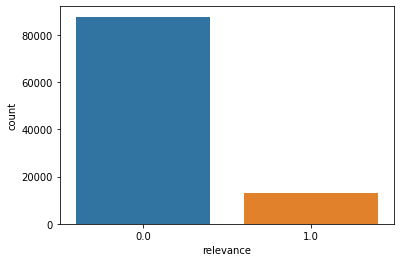

Negative Sampling Ratio: 6.632730300507153


In [157]:
#Test for negative sampling ratio
rel = (ml_df["relevance"] == 1.0).sum()
non_rel = (ml_df["relevance"] != 1.0).sum()
print("relevance number:     ", rel ,"\nnon-relevance number: ", non_rel)

sns.countplot(x="relevance", data=ml_df)
plt.show()
print("Negative Sampling Ratio: " + str(non_rel / rel))

In [158]:
#Split dataset between train, eval and test
full_df = ml_df
eval_df = full_df.sample(frac=0.05)
full_df = full_df.drop(eval_df.index)
test_df = full_df.sample(frac=0.05)
train_df = full_df.drop(test_df.index)

In [159]:
#Store number of datapoints in each dataset
train_count = train_df.shape[0]
eval_count = eval_df.shape[0]
test_count = test_df.shape[0]
print("Train samples: " + str(train_count))
print("Evaluation samples: " + str(eval_count))
print("Test samples: " + str(test_count))

Train samples: 91004
Evaluation samples: 5042
Test samples: 4790


In [160]:
#Create Datasets for train, evaluation and testing
train_ds = tf.data.Dataset.from_tensor_slices(({"userId":train_df["userId"],
                                                "movieId":train_df["movieId"]},
                                                train_df["relevance"].values.reshape([-1, 1]))).shuffle(4196)

eval_ds = tf.data.Dataset.from_tensor_slices(({"userId":eval_df["userId"],
                                               "movieId":eval_df["movieId"]},
                                               eval_df["relevance"].values.reshape([-1, 1]))).batch(eval_count)

test_ds = tf.data.Dataset.from_tensor_slices(({"userId":test_df["userId"],
                                               "movieId":test_df["movieId"]}, 
                                               test_df["relevance"].values.reshape([-1, 1]))).batch(test_count)

Generalized Matrix Factorization

In [161]:
class DenseBlock(tf.keras.layers.Layer):

  def __init__(self, units, activation="relu", dropout=0.1, l2=0.001):
    super(DenseBlock, self).__init__()

    self.bn = tf.keras.layers.BatchNormalization()
    self.drop = tf.keras.layers.Dropout(dropout)
    self.dense = tf.keras.layers.Dense(units, 
                                       activation,
                                       kernel_regularizer=tf.keras.regularizers.L1L2(l2=l2),
                                       kernel_constraint=tf.keras.constraints.UnitNorm())
    
  def call(self, inputs):
    X = self.bn(inputs)
    X = self.drop(X)
    X = self.dense(X)
    return X

In [162]:
class GeneralizedMatrixFactorizer(tf.keras.Model):

  def __init__(self, 
               alpha_dim, 
               beta_dim, 
               latent_dim,
               output_dim,
               output_activation="sigmoid",
               use_bias=False, 
               dropout=0.1, 
               l2=1e-5, 
               alpha_key="alpha", 
               beta_key="beta"):
    
    super(GeneralizedMatrixFactorizer, self).__init__()

    self.use_bias = use_bias
    self.alpha_key = alpha_key
    self.beta_key = beta_key

    self.alpha_emb = tf.keras.layers.Embedding(alpha_dim, latent_dim, 
                                               embeddings_regularizer=tf.keras.regularizers.L1L2(l2=l2))
    
    self.beta_emb = tf.keras.layers.Embedding(beta_dim, latent_dim, 
                                              embeddings_regularizer=tf.keras.regularizers.L1L2(l2=l2))

    if(use_bias):
      self.alpha_bias = tf.keras.layers.Embedding(alpha_dim, 1)
      self.beta_bias = tf.keras.layers.Embedding(beta_dim, 1)
    
    self.flat = tf.keras.layers.Flatten()
    self.mul = tf.keras.layers.Multiply()    #Element-wise Product of Embeddings 
    self.out = DenseBlock(output_dim, output_activation, dropout, l2)


  def call(self, inputs):

    alpha_emb = self.alpha_emb(inputs[self.alpha_key])
    alpha_emb = self.flat(alpha_emb)
    beta_emb = self.beta_emb(inputs[self.beta_key])
    beta_emb = self.flat(beta_emb)

    X = self.mul([alpha_emb, beta_emb]) 

    if(self.use_bias): 
      alpha_bias = self.alpha_bias(inputs[self.alpha_key])
      alpha_bias = self.flat(alpha_bias)
      beta_bias = self.beta_bias(inputs[self.beta_key])
      beta_bias = self.flat(beta_bias)
      bias = tf.add(alpha_bias, beta_bias)
      X = tf.add(X, bias)

    X = self.out(X)
    return X   

In [163]:
#Hyper-parameters
gmf_params = {"alpha_dim":n_users,
              "beta_dim":n_movies,
              "latent_dim":8,
              "output_dim":1,
              "output_activation":"sigmoid",
              "use_bias":False,
              "dropout":0.4,
              "l2":0.001,
              "learning_rate":0.001,
              "batch_size":256,
              "epochs":50}

In [164]:
#Instantiation
gmf = GeneralizedMatrixFactorizer(alpha_dim=gmf_params["alpha_dim"], 
                                  beta_dim=gmf_params["beta_dim"], 
                                  latent_dim = gmf_params["latent_dim"], 
                                  output_dim=gmf_params["output_dim"], 
                                  output_activation=gmf_params["output_activation"],
                                  use_bias=gmf_params["use_bias"],
                                  dropout=gmf_params["dropout"],
                                  l2=gmf_params["l2"], 
                                  alpha_key="userId", 
                                  beta_key="movieId")

gmf.compile(tf.keras.optimizers.Adam(gmf_params["learning_rate"]), 
            tf.keras.losses.BinaryCrossentropy(), 
            metrics=[tf.keras.metrics.BinaryAccuracy()])

In [165]:
#Fitting
historyGMF= gmf.fit(train_ds.batch(gmf_params["batch_size"]), 
                    epochs=gmf_params["epochs"], 
                    validation_data=eval_ds, 
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/50
356/356 [==============================] - 3s 5ms/step - loss: 0.5414 - binary_accuracy: 0.8626 - val_loss: 0.4375 - val_binary_accuracy: 0.8711
Epoch 2/50
356/356 [==============================] - 1s 4ms/step - loss: 0.4174 - binary_accuracy: 0.8691 - val_loss: 0.3929 - val_binary_accuracy: 0.8711
Epoch 3/50
356/356 [==============================] - 1s 4ms/step - loss: 0.4004 - binary_accuracy: 0.8691 - val_loss: 0.3868 - val_binary_accuracy: 0.8711
Epoch 4/50
356/356 [==============================] - 1s 4ms/step - loss: 0.3969 - binary_accuracy: 0.8692 - val_loss: 0.3805 - val_binary_accuracy: 0.8705
Epoch 5/50
356/356 [==============================] - 2s 4ms/step - loss: 0.3861 - binary_accuracy: 0.8713 - val_loss: 0.3700 - val_binary_accuracy: 0.8729
Epoch 6/50
356/356 [==============================] - 1s 4ms/step - loss: 0.3768 - binary_accuracy: 0.8732 - val_loss: 0.3640 - val_binary_accuracy: 0.8723
Epoch 7/50
356/356 [==============================] - 1s 4ms/ste

In [166]:
gmf.evaluate(test_ds)

1/1 [==============================] - 0s 27ms/step - loss: 0.3623 - binary_accuracy: 0.8752


[0.3622564375400543, 0.875156581401825]

Neural Collaborative Filtering

In [167]:
class DeepFeedForward(tf.keras.Model):

  def __init__(self, layers, dropout=0.1, l2=0.001):
    super(DeepFeedForward, self).__init__()

    self.block_list = list()
    for layer in layers:
      self.block_list.append(DenseBlock(layer, "relu", dropout, l2))
    
  def call(self, inputs):

    X = inputs
    for layer in self.block_list:
      X = layer(X)
    return X

In [168]:
class NCFNetwork(tf.keras.Model):

  def __init__(self, 
               alpha_dim, 
               beta_dim, 
               latent_dim, 
               layers, 
               output_activation="sigmoid",
               use_bias=False, 
               dropout=0.1, 
               l2=0.001, 
               alpha_key="alpha", 
               beta_key="beta"):
    
    super(NCFNetwork, self).__init__()

    self.alpha_key = alpha_key
    self.beta_key = beta_key
    self.use_bias = use_bias

    self.alpha_emb = tf.keras.layers.Embedding(alpha_dim, latent_dim, embeddings_regularizer=tf.keras.regularizers.L1L2(l2=l2))
    self.beta_emb = tf.keras.layers.Embedding(beta_dim, latent_dim, embeddings_regularizer=tf.keras.regularizers.L1L2(l2=l2))

    if(use_bias):
      self.alpha_bias = tf.keras.layers.Embedding(alpha_dim, 1)
      self.beta_bias = tf.keras.layers.Embedding(beta_dim, 1)
    
    self.flat = tf.keras.layers.Flatten()
    self.feedforward = DeepFeedForward(layers[:-1], dropout, l2)
    self.dense_out = DenseBlock(layers[-1], output_activation, dropout, l2)

  def call(self, inputs):

    alpha_emb = self.flat(self.alpha_emb(inputs[self.alpha_key]))
    beta_emb = self.flat(self.beta_emb(inputs[self.beta_key]))
    X = tf.concat([alpha_emb, beta_emb], axis=-1)

    if(self.use_bias):
      alpha_bias = self.flat(self.alpha_bias(inputs[self.alpha_key]))
      beta_bias = self.flat(self.beta_bias(inputs[self.beta_key]))
      bias = tf.add(alpha_bias, beta_bias)
      X = tf.add(X, bias)

    X = self.feedforward(X)
    X = self.dense_out(X)
    return X

In [169]:
#Hyper parameters
ncf_params = {"alpha_dim":n_users,
              "beta_dim":n_movies,
              "latent_dim":8,
              "layers":[32, 16, 8, 1],
              "output_activation":"sigmoid",
              "use_bias":False,
              "dropout":0.4,
              "l2":0.001,
              "learning_rate":0.001,
              "batch_size":256,
              "epochs":50}

In [170]:
#Instantiation
ncf = NCFNetwork(alpha_dim=ncf_params["alpha_dim"], 
                 beta_dim=ncf_params["beta_dim"], 
                 latent_dim=ncf_params["latent_dim"], 
                 layers=ncf_params["layers"],
                 output_activation=ncf_params["output_activation"],
                 use_bias=ncf_params["use_bias"],
                 dropout=ncf_params["dropout"], 
                 l2=ncf_params["l2"], 
                 alpha_key="userId",
                 beta_key="movieId")

ncf.compile(tf.keras.optimizers.Adam(ncf_params["learning_rate"]), 
            tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()])

In [171]:
#Fitting
historyNCF= historyN=ncf.fit(train_ds.batch(ncf_params["batch_size"]), 
                             epochs=ncf_params["epochs"], 
                             validation_data=eval_ds, 
                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/50
356/356 [==============================] - 5s 6ms/step - loss: 0.6817 - binary_accuracy: 0.6970 - val_loss: 0.5101 - val_binary_accuracy: 0.8711
Epoch 2/50
356/356 [==============================] - 2s 6ms/step - loss: 0.5022 - binary_accuracy: 0.8591 - val_loss: 0.4464 - val_binary_accuracy: 0.8711
Epoch 3/50
356/356 [==============================] - 2s 6ms/step - loss: 0.4577 - binary_accuracy: 0.8670 - val_loss: 0.4093 - val_binary_accuracy: 0.8711
Epoch 4/50
356/356 [==============================] - 2s 6ms/step - loss: 0.4276 - binary_accuracy: 0.8690 - val_loss: 0.3868 - val_binary_accuracy: 0.8719
Epoch 5/50
356/356 [==============================] - 2s 6ms/step - loss: 0.4107 - binary_accuracy: 0.8691 - val_loss: 0.3823 - val_binary_accuracy: 0.8715
Epoch 6/50
356/356 [==============================] - 2s 6ms/step - loss: 0.3997 - binary_accuracy: 0.8708 - val_loss: 0.3841 - val_binary_accuracy: 0.8721
Epoch 7/50
356/356 [==============================] - 2s 6ms/ste

In [172]:
ncf.evaluate(test_ds)

1/1 [==============================] - 0s 29ms/step - loss: 0.3922 - binary_accuracy: 0.8685


[0.39222198724746704, 0.8684759736061096]

Naural Matrix Factorization

In [173]:
class NeuMF(tf.keras.Model):

  def __init__(self, 
               alpha_dim, 
               beta_dim, 
               NCF_latent_dim, 
               GMF_latent_dim, 
               NCF_layers,
               GMF_output_dim, 
               NeuMF_output_dim,
               NCF_output_activation="relu",
               GMF_output_activation="relu",
               NeuMF_output_activation="sigmoid", 
               output_weight=0.5, 
               use_bias=False, 
               dropout=0.1, 
               l2=0.001, 
               alpha_key="alpha", 
               beta_key="beta"):
    
    super(NeuMF, self).__init__()

    self.output_weight = output_weight

    self.NCF = NCFNetwork(alpha_dim, 
                          beta_dim, 
                          NCF_latent_dim, 
                          NCF_layers, 
                          NCF_output_activation, 
                          use_bias, 
                          dropout, 
                          l2, 
                          alpha_key, 
                          beta_key)
    
    self.GMF = GeneralizedMatrixFactorizer(alpha_dim, 
                                           beta_dim, 
                                           GMF_latent_dim, 
                                           GMF_output_dim, 
                                           GMF_output_activation, 
                                           use_bias, 
                                           dropout, 
                                           l2, 
                                           alpha_key, 
                                           beta_key)
    
    self.dense_out = DenseBlock(NeuMF_output_dim, NeuMF_output_activation, dropout, l2)

  def call(self, inputs):
    ncf = self.NCF(inputs) * (1.0 - self.output_weight)
    gmf = self.GMF(inputs) * self.output_weight

    X = tf.concat([ncf, gmf], axis=-1)
    X = self.dense_out(X)
    return X

In [174]:
nmf_params = {"alpha_dim":n_users,
              "beta_dim":n_movies,
              "NCF_latent_dim":8, 
              "GMF_latent_dim":8, 
              "NCF_layers":[32, 16, 8, 1],
              "GMF_output_dim":1, 
              "NeuMF_output_dim":1,
              "output_weight":0.5,
              "use_bias":False,
              "dropout":0.4,
              "l2":0.001,
              "learning_rate":0.001,            #[0.0001, 0.0005, 0.001, 0.005]
              "batch_size":256,                 #[128, 256, 512, 1024]
              "epochs":50}

In [175]:
#Instantiation
nmf = NeuMF(alpha_dim=nmf_params["alpha_dim"], 
            beta_dim=nmf_params["beta_dim"], 
            NCF_latent_dim=nmf_params["NCF_latent_dim"],
            GMF_latent_dim=nmf_params["GMF_latent_dim"],
            NCF_layers=nmf_params["NCF_layers"],
            GMF_output_dim=nmf_params["GMF_output_dim"],
            NeuMF_output_dim=nmf_params["NeuMF_output_dim"],
            output_weight=nmf_params["output_weight"],
            use_bias=nmf_params["use_bias"], 
            dropout=nmf_params["dropout"],
            l2=nmf_params["l2"], 
            alpha_key="userId", 
            beta_key="movieId")

nmf.compile(tf.keras.optimizers.Adam(nmf_params["learning_rate"]), 
            tf.keras.losses.BinaryCrossentropy(), 
            metrics=[tf.keras.metrics.BinaryAccuracy()])


In [176]:
#Fitting
historyNM=nmf.fit(train_ds.batch(nmf_params["batch_size"]), 
                  epochs=nmf_params["epochs"], 
                  validation_data=eval_ds, 
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/50
356/356 [==============================] - 6s 8ms/step - loss: 0.6633 - binary_accuracy: 0.8289 - val_loss: 0.5520 - val_binary_accuracy: 0.8711
Epoch 2/50
356/356 [==============================] - 3s 7ms/step - loss: 0.5265 - binary_accuracy: 0.8639 - val_loss: 0.4635 - val_binary_accuracy: 0.8713
Epoch 3/50
356/356 [==============================] - 3s 7ms/step - loss: 0.4726 - binary_accuracy: 0.8685 - val_loss: 0.4290 - val_binary_accuracy: 0.8715
Epoch 4/50
356/356 [==============================] - 3s 7ms/step - loss: 0.4549 - binary_accuracy: 0.8706 - val_loss: 0.4171 - val_binary_accuracy: 0.8703
Epoch 5/50
356/356 [==============================] - 3s 7ms/step - loss: 0.4456 - binary_accuracy: 0.8715 - val_loss: 0.4126 - val_binary_accuracy: 0.8707
Epoch 6/50
356/356 [==============================] - 3s 7ms/step - loss: 0.4384 - binary_accuracy: 0.8733 - val_loss: 0.4138 - val_binary_accuracy: 0.8721
Epoch 7/50
356/356 [==============================] - 3s 7ms/ste

In [177]:
nmf.evaluate(test_ds)

1/1 [==============================] - 0s 32ms/step - loss: 0.4217 - binary_accuracy: 0.8683


[0.42174768447875977, 0.8682672381401062]

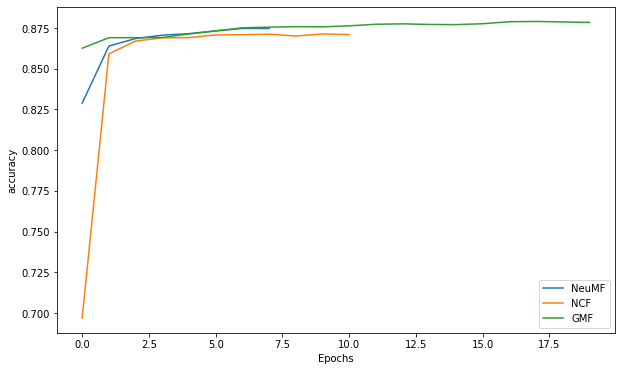

In [178]:
plt.figure(figsize=(10,6)) 
plt.plot(historyNM.history['binary_accuracy'])
plt.plot(historyNCF.history['binary_accuracy'])
plt.plot(historyGMF.history['binary_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(["NeuMF","NCF","GMF"])
plt.show()